In [6]:
%run ../Latex_macros.ipynb
%run ../beautify_plots.py

<IPython.core.display.Latex object>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

import ipywidgets as widgets
from IPython.display import display, clear_output

In [8]:
from ensembles_study import *

In [9]:
# Widgets
p_slider = widgets.FloatSlider(value=0.55, min=0.0, max=1.0, step=0.001, description="p", readout_format=".3f")
p_box    = widgets.BoundedFloatText(value=0.55, min=0.0, max=1.0, step=0.001, description="p input")
widgets.jslink((p_slider, "value"), (p_box, "value"))  # keep them synced

M_min = widgets.IntSlider(value=10, min=1, max=999, step=1, description="M min")
M_max = widgets.IntSlider(value=200, min=2, max=1000, step=1, description="M max")
include_tie = widgets.Checkbox(value=False, description="Include tie (M even)")

out = widgets.Output()

def refresh(_=None):
    with out:
        clear_output(wait=True)
        m1, m2 = M_min.value, M_max.value
        if m2 <= m1:
            print("Set M max > M min")
            return
        plot(m1, m2, p_slider.value, include_tie.value)

for w in [p_slider, p_box, M_min, M_max, include_tie]:
    w.observe(refresh, names="value")

display(widgets.VBox([
    widgets.HBox([p_slider, p_box]),
    widgets.HBox([M_min, M_max, include_tie]),
    out
]))

refresh()




# 1. What We Actually Want

Suppose:

* Each classifier has accuracy ( A = $\mathbb P(\text{correct})$ )
* Errors are independent
* We have ( M ) classifiers
* Majority vote
* Binary classification

Let


$$X \sim \text{Binomial}(M, A)$$

where ( X ) = number of correct classifiers.

---

## Majority vote is correct iff:


$X \ge \left\lceil \frac{M}{2} \right\rceil$


So the true probability of ensemble correctness is:


$$\boxed{
\mathbb P(\text{majority correct}) = \sum_{m=\lceil M/2\rceil}^{M}
\binom{M}{m}
A^m (1-A)^{M-m}
}
$$

In particular
we must sum over all (m), and
the probability term must be (A^m(1-A)^{M-m}).

<!-- The slide’s formula using only ((1-A)^{m'}) is incomplete. -->

---

# 2. Why Does This Go to 1?

Now the real question:

Does this probability → 1 as (M \to \infty)?

Answer:

Yes, **if and only if** (A > 1/2).

---

## Intuition via Law of Large Numbers

$\frac{X}{M} \to A$

If (A > 1/2), then for large (M),

$
X > M/2
$

with probability → 1.

So majority vote becomes almost surely correct.

---

# 3. Clean Proof via CLT

Using Central Limit Theorem:

$$\frac{X - MA}{\sqrt{M A (1-A)}} \to \mathcal N(0,1)$$

We want:

$$\mathbb P\left( X \ge \frac{M}{2} \right)
=\mathbb P\left(
\frac{X - MA}{\sqrt{M A (1-A)}}
\ge
\frac{M/2 - MA}{\sqrt{M A (1-A)}}
\right)
$$

Now look at the threshold:


$$\frac{M/2 - MA}{\sqrt{M A (1-A)}}
=\frac{M(1/2 - A)}{\sqrt{M A (1-A)}}
= \sqrt{M} \cdot \frac{1/2 - A}{\sqrt{A(1-A)}}
$$

If (A > 1/2),
then
$
1/2 - A < 0
$

so the RHS → $-\infty$ as $M \to \infty$.

Thus:

$
\mathbb P(\text{majority correct}) \to 1.
$

<!-- ---

# 4. When Is The Slide Argument Wrong?

The slide says:

> "Since (1-A) < 1, raising to power m' makes it go to 0."

That argument is flawed because:

* It ignores the binomial coefficient
* It ignores summing over all majority cases
* It ignores the symmetric term (A^m)

So yes — the slide’s reasoning is incomplete.

--- -->

# Important Subtlety

This convergence to 1 only holds if:


$A > 1/2$


If:

* \(A = 1/2\) → ensemble accuracy = 1/2
* \(A < 1/2\) → ensemble accuracy → 0

So ensemble only helps if learners are weak but **better than chance**.

---

# The Deeper Insight (Boosting Philosophy)

The real ensemble miracle is:

Even if

[
A = 0.51
]

we get exponential improvement in error:

$
\mathbb P(\text{majority wrong})
\approx
\exp(-c M)
$

(Chernoff bound)

So error shrinks exponentially fast in (M).

That’s the real reason boosting works.





# Experiment: Majority-Vote Ensemble

## Goal

We want to empirically verify the theoretical claim:

> A majority-vote ensemble improves performance **only if each individual classifier is better than random guessing** (accuracy > 0.5).
> If individual classifiers are worse than random (accuracy < 0.5), the ensemble becomes worse as we add more models.

Mathematically this comes from:

$
P(\text{ensemble correct})
=\sum_{m=\lceil M/2\rceil}^{M}
\binom{M}{m} A^m (1-A)^{M-m}
$

where (A) is the accuracy of a single classifier.

As (M \to \infty):

* If (A > 0.5) → probability → **1**
* If (A < 0.5) → probability → **0**

---

## What the Code Does

### Dataset

We use the **Breast Cancer dataset** (binary classification) so majority voting directly matches the binomial theory.

---

### Weak Classifiers (Base Learners)

We generate many weak classifiers:

* Decision tree stump (depth = 1)
* Trained on bootstrap sample (bagging)
* Uses only a small subset of features

Each classifier is therefore only slightly predictive.

This mimics theoretical assumptions:

* independent (or weakly correlated) voters
* identical accuracy (A)

---

### Two Scenarios

#### Scenario 2 — Good learners

We use classifiers normally.

Each classifier has accuracy slightly above 50%:

[
A > 0.5
]

We compute majority vote accuracy as number of voters (M) increases.

---

#### Scenario 1 — Bad learners

We flip every classifier’s prediction:

$
\hat y_{\text{bad}} = 1 - \hat y
$

So now each classifier has:

$
A < 0.5
$

Then we again compute majority vote accuracy as (M) increases.

---

## What the Plot Shows

### Blue curve — good learners (A > 0.5)

As number of voters increases:

$
\text{ensemble accuracy} \uparrow
$

The ensemble becomes very accurate (~93%).

This matches theory:

$
P(\text{majority correct}) \to 1
$

--

### Orange curve — bad learners (A < 0.5)

As number of voters increases:

$
\text{ensemble accuracy} \downarrow
$

The ensemble becomes extremely wrong (~5–10%).

This matches theory:

$
P(\text{majority correct}) \to 0
$

---

## Interpretation

The experiment demonstrates a **phase transition at 50% accuracy**:

| Single Model Accuracy | Ensemble Effect                |
| --------------------- | ------------------------------ |
| (A > 0.5)             | Ensemble improves dramatically |
| (A = 0.5)             | Ensemble does nothing          |
| (A < 0.5)             | Ensemble amplifies error       |

So ensemble learning does **not magically fix bad models**.

It only amplifies weak but *useful* information.

---

## Intuition

Each model is like a noisy voter:

* If voters are slightly reliable → crowd wisdom works
* If voters are slightly wrong → crowd stupidity emerges

Majority voting amplifies bias.

---

## Conclusion

This experiment empirically validates the theoretical result:

[
\boxed{
\text{Ensembling works only if each learner is better than random guessing.}
}
]

The power of ensembles comes from combining many weak but positively informative predictors — not from correcting systematically wrong ones.

---


Scenario 2 base learners (unflipped): mean acc = 0.761, median = 0.750
Scenario 1 base learners (flipped):   mean acc = 0.239, median = 0.250


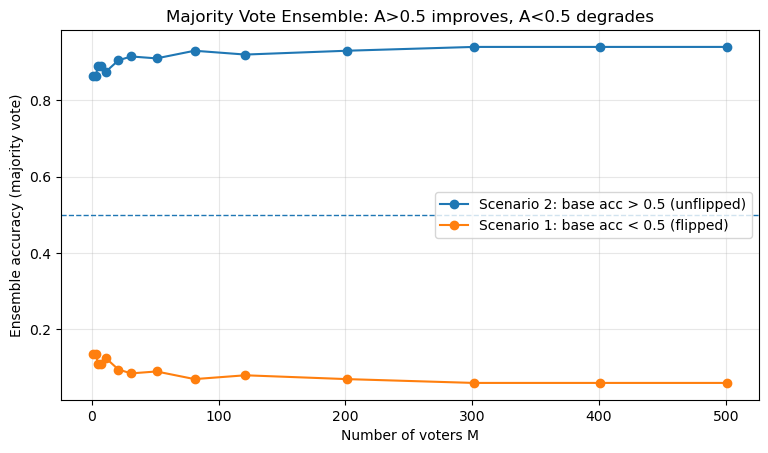


M   ensemble_good   ensemble_bad
1          0.865         0.135
3          0.865         0.135
5          0.890         0.110
7          0.890         0.110
11         0.875         0.125
21         0.905         0.095
31         0.915         0.085
51         0.910         0.090
81         0.930         0.070
121        0.920         0.080
201        0.930         0.070
301        0.940         0.060
401        0.940         0.060
501        0.940         0.060


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# ----------------------------
# 1) Data (binary classification)
# ----------------------------
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

rng = np.random.default_rng(123)

# ----------------------------
# 2) Build a pool of weak-ish voters
#    - decision stump (depth=1)
#    - trained on bootstrap sample
#    - uses ONE random feature to reduce strength & correlation
# ----------------------------
def train_stump_one_feature(Xtr, ytr, rng):
    n, d = Xtr.shape
    feat = rng.integers(0, d)
    boot_idx = rng.integers(0, n, size=n)  # bootstrap sample

    clf = DecisionTreeClassifier(max_depth=1, random_state=int(rng.integers(1_000_000_000)))
    clf.fit(Xtr[boot_idx][:,[feat]], ytr[boot_idx])
    # clf.fit(Xtr[boot_idx, [feat]], ytr[boot_idx])  # this will fail to make X 2D for sklearn, so we use [:,[feat]] instead of [,feat]
    return clf, feat

def majority_vote(preds_2d):
    """
    preds_2d: shape (M, N) with binary predictions in {0,1}
    returns: shape (N,) majority vote
    """
    votes = preds_2d.sum(axis=0)
    # tie-break: if tie (only possible when M even), predict 1 (arbitrary)
    return (votes >= (preds_2d.shape[0] / 2)).astype(int)

# Train a reasonably large pool once, then evaluate prefixes of size M
POOL = 501
models = [train_stump_one_feature(X_train, y_train, rng) for _ in range(POOL)]

# Precompute each model's predictions on test set (faster)
preds_pool = []
for clf, feat in models:
    preds_pool.append(clf.predict(X_test[:, [feat]]))
preds_pool = np.array(preds_pool)  # (POOL, N)

# Individual accuracies in the "good" scenario
ind_acc_good = np.array([accuracy_score(y_test, preds_pool[i]) for i in range(POOL)])
print(f"Scenario 2 base learners (unflipped): mean acc = {ind_acc_good.mean():.3f}, "
      f"median = {np.median(ind_acc_good):.3f}")

# "Bad" scenario: flip every base learner => accuracy becomes ~ 1 - acc
preds_pool_bad = 1 - preds_pool
ind_acc_bad = np.array([accuracy_score(y_test, preds_pool_bad[i]) for i in range(POOL)])
print(f"Scenario 1 base learners (flipped):   mean acc = {ind_acc_bad.mean():.3f}, "
      f"median = {np.median(ind_acc_bad):.3f}")

# ----------------------------
# 3) Evaluate ensemble accuracy as M grows
# ----------------------------
Ms = np.array([1, 3, 5, 7, 11, 21, 31, 51, 81, 121, 201, 301, 401, 501])

ens_good = []
ens_bad = []

for M in Ms:
    mv_good = majority_vote(preds_pool[:M])
    mv_bad  = majority_vote(preds_pool_bad[:M])
    ens_good.append(accuracy_score(y_test, mv_good))
    ens_bad.append(accuracy_score(y_test, mv_bad))

ens_good = np.array(ens_good)
ens_bad = np.array(ens_bad)

# ----------------------------
# 4) Plot
# ----------------------------
plt.figure(figsize=(9, 4.8))
plt.plot(Ms, ens_good, marker="o", label="Scenario 2: base acc > 0.5 (unflipped)")
plt.plot(Ms, ens_bad,  marker="o", label="Scenario 1: base acc < 0.5 (flipped)")
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.xlabel("Number of voters M")
plt.ylabel("Ensemble accuracy (majority vote)")
plt.title("Majority Vote Ensemble: A>0.5 improves, A<0.5 degrades")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print a small table
print("\nM   ensemble_good   ensemble_bad")
for M, g, b in zip(Ms, ens_good, ens_bad):
    print(f"{M:<3d} {g:>12.3f} {b:>13.3f}")
